# Quickstart


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qc_lab import Simulation 
from qc_lab.models import SpinBosonModel
from qc_lab.algorithms import MeanField 
from qc_lab.dynamics import serial_driver

# instantiate a simulation
sim = Simulation()
print('default simulation settings: ', sim.default_settings)

# change settings to customize simulation
sim.settings.num_trajs = 200
sim.settings.batch_size = 25
sim.settings.tmax = 30
sim.settings.dt = 0.001

# instantiate a model 
sim.model = SpinBosonModel()
print('default model constants: ', sim.model.default_constants) # print out default constants

# instantiate an algorithm 
sim.algorithm = MeanField()
print('default algorithm settings: ', sim.algorithm.default_settings) # print out default settings



# define an initial diabatic wavefunction 
sim.state.wf_db = np.array([1, 0], dtype=complex)

# run the simulation
data = serial_driver(sim)



default simulation settings:  {'tmax': 10, 'dt': 0.01, 'dt_output': 0.1, 'num_trajs': 10, 'batch_size': 1}
default model constants:  {'temp': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1, 'l_reorg': 0.005, 'boson_mass': 1}
default algorithm settings:  {}


100%|██████████| 30001/30001 [00:10<00:00, 2830.21it/s]


calculated quantities: dict_keys(['seed', 'dm_db', 'classical_energy', 'quantum_energy'])


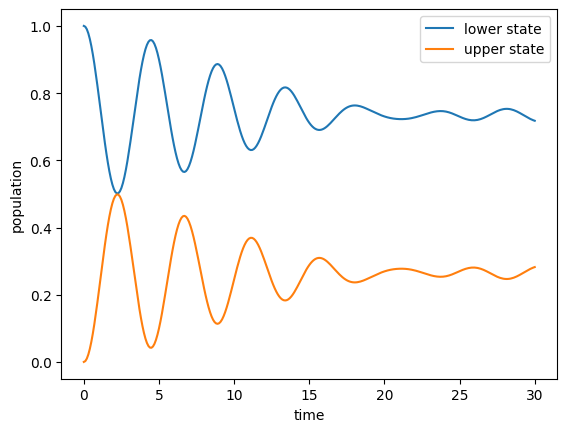

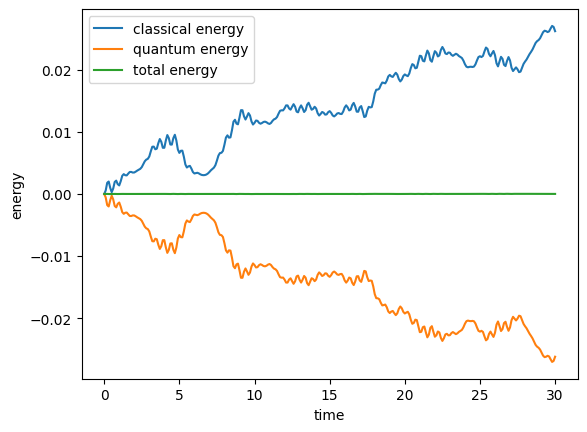

In [6]:
print('calculated quantities:', data.data_dic.keys())
num_trajs = len(data.data_dic['seed'])
classical_energy = data.data_dic['classical_energy']/num_trajs
quantum_energy = data.data_dic['quantum_energy']/num_trajs
populations = np.real(np.einsum('tii->ti', data.data_dic['dm_db']/num_trajs))
time = sim.settings.tdat_output
plt.plot(time, populations[:,0], label='lower state')
plt.plot(time, populations[:,1], label='upper state')
plt.xlabel('time')
plt.ylabel('population')
plt.legend()
plt.savefig('../docs/user_guide/quickstart/quickstart_populations.png')
plt.show()
plt.plot(time, classical_energy - classical_energy[0], label='classical energy')
plt.plot(time, quantum_energy - quantum_energy[0], label='quantum energy')
plt.plot(time, classical_energy + quantum_energy - classical_energy[0] - quantum_energy[0], label='total energy')
plt.xlabel('time')
plt.ylabel('energy')
plt.legend()
plt.savefig('../docs/user_guide/quickstart/quickstart_energies.png')
plt.show()

In [5]:
from qc_lab.algorithms import FewestSwitchesSurfaceHopping

sim.algorithm = FewestSwitchesSurfaceHopping()

data = serial_driver(sim)

100%|██████████| 30001/30001 [00:15<00:00, 1888.82it/s]


In [3]:
from qclab import Model
class MinimalSpinBoson(Model):
    def __init__(self, parameters = None):
        if parameters is None:
            parameters = {}
        self.default_parameters = {
            'temp': 1, 'V': 0.5, 'E': 0.5, 'A': 2, 'W': 0.1,
            'l_reorg': 0.02 / 4, 'boson_mass': 1
        }
        super().__init__(self.default_parameters, parameters)

    def update_model_parameters(self):
        self.parameters.w = self.parameters.W * np.tan(((np.arange(self.parameters.A) + 1) - 0.5) * np.pi / (2 * self.parameters.A))
        self.parameters.g = self.parameters.w * np.sqrt(2 * self.parameters.l_reorg / self.parameters.A) 
        self.parameters.pq_weight = self.parameters.w
        self.parameters.num_classical_coordinates = self.parameters.A
        self.parameters.mass = np.ones(self.parameters.A) * self.parameters.boson_mass

    def h_q(self, **kwargs):
        E = self.parameters.E
        V = self.parameters.V
        return np.array([[E, V], [V, -E]], dtype=complex)

    def h_qc(self, **kwargs):
        z_coord = kwargs['z_coord']
        g = self.parameters.g
        m = self.parameters.mass
        h = self.parameters.pq_weight
        h_qc = np.zeros((2, 2), dtype=complex)
        h_qc[0, 0] = np.sum((g * np.sqrt(1 / (2 * m * h))) * (z_coord + np.conj(z_coord)))
        h_qc[1, 1] = -h_qc[0, 0]
        return h_qc
    

    def h_c(self, **kwargs):
        z_coord = kwargs['z_coord']
        w = self.parameters.w
        return np.sum(w * np.conj(z_coord) * z_coord)

import numpy as np
import matplotlib.pyplot as plt
from qclab import Simulation
from qclab.algorithms import MeanField
from qclab.dynamics import serial_driver

# instantiate a simulation
sim = Simulation()
print('default simulation parameters: ', sim.default_parameters)

# change parameters to customize simulation
sim.parameters.num_trajs = 200#200
sim.parameters.batch_size = 20#20
sim.parameters.tmax = 30
sim.parameters.dt = 0.001

print(sim.parameters.__dict__)
sim.model = MinimalSpinBoson()

# instantiate an algorithm 
sim.algorithm = MeanField()
print('default algorithm parameters: ', sim.algorithm.default_parameters) # print out default parameters



# define an initial diabatic wavefunction 
sim.state.modify('wf_db',np.array([1, 0], dtype=np.complex128))


data = serial_driver(sim)


/home/akrotz/Research/pyMQC/qclab/tasks.py:384: UserWarning: h_q_vectorized not implemented for this model. Using non-vectorized method.
  warnings.warn("h_q_vectorized not implemented for this model. Using non-vectorized method.", UserWarning)
/home/akrotz/Research/pyMQC/qclab/tasks.py:389: UserWarning: h_qc_vectorized not implemented for this model. Using non-vectorized method.
  warnings.warn("h_qc_vectorized not implemented for this model. Using non-vectorized method.", UserWarning)
/home/akrotz/Research/pyMQC/qclab/tasks.py:131: UserWarning: dh_c_dzc_vectorized not implemented for this model. Using non-vectorized method.
  warnings.warn("dh_c_dzc_vectorized not implemented for this model. Using non-vectorized method.", UserWarning)
/home/akrotz/Research/pyMQC/qclab/tasks.py:135: UserWarning: dh_c_dzc not implemented for this model. Using finite differences.
  warnings.warn("dh_c_dzc not implemented for this model. Using finite differences.", UserWarning)
/home/akrotz/Research/pyMQ

default simulation parameters:  {'tmax': 10, 'dt': 0.01, 'dt_output': 0.1, 'num_trajs': 10, 'batch_size': 1}
{'_updating': False, '_init_complete': False, '_update_function': None, 'tmax': 30, 'dt': 0.001, 'dt_output': 0.1, 'num_trajs': 200, 'batch_size': 20}
default algorithm parameters:  {}


  0%|          | 0/30001 [00:00<?, ?it/s]

 30%|███       | 9015/30001 [01:22<03:12, 109.14it/s]


KeyboardInterrupt: 

calculated quantities: dict_keys(['seed', 'dm_db', 'classical_energy', 'quantum_energy'])
2
[0 1]
[3.42362692+3.95087531e-19j]
[0.61231679+0.j]


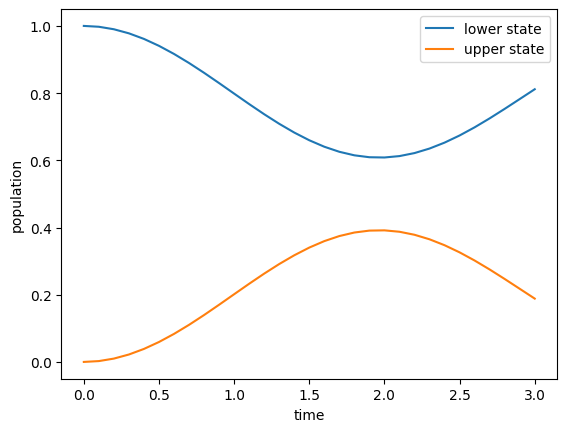

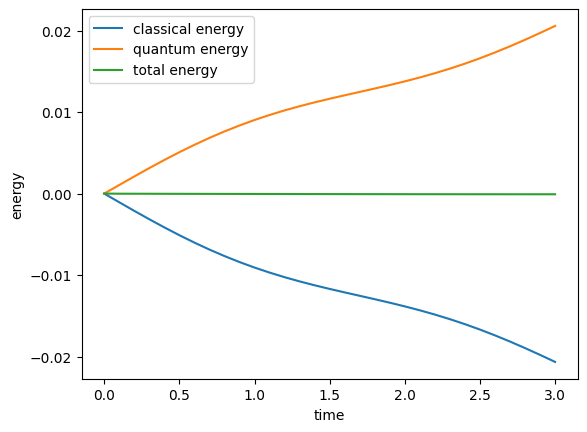

In [5]:
print('calculated quantities:', data.data_dic.keys())
num_trajs = len(data.data_dic['seed'])
print(num_trajs)
print(data.data_dic['seed'])
classical_energy = data.data_dic['classical_energy']/num_trajs
print(classical_energy[0])
quantum_energy = data.data_dic['quantum_energy']/num_trajs
print(quantum_energy[0])
populations = np.real(np.einsum('tii->ti', data.data_dic['dm_db']/num_trajs))
time = sim.parameters.tdat_output
plt.plot(time, populations[:,0], label='lower state')
plt.plot(time, populations[:,1], label='upper state')
plt.xlabel('time')
plt.ylabel('population')
plt.legend()
#plt.savefig('quickstart_populations.png')
plt.show()
plt.plot(time, classical_energy - classical_energy[0], label='classical energy')
plt.plot(time, quantum_energy - quantum_energy[0], label='quantum energy')
plt.plot(time, classical_energy + quantum_energy - classical_energy[0] - quantum_energy[0], label='total energy')
plt.xlabel('time')
plt.ylabel('energy')
plt.legend()
#plt.savefig('quickstart_energies.png')
plt.show()


In [5]:
from qclab import Model, ingredients
class SpinBosonModel(Model):
    def __init__(self, parameters=None):
        if parameters is None:
            parameters = {}
        self.default_parameters = {
            'temp': 1, 'V': 0.5, 'E': 0.5, 'A': 100, 'W': 0.1,
            'l_reorg': 0.02 / 4, 'boson_mass': 1
        }
        super().__init__(self.default_parameters, parameters)

    def update_model_parameters(self):
        self.parameters.w = self.parameters.W * np.tan(((np.arange(self.parameters.A) + 1) - 0.5) * np.pi / (2 * self.parameters.A))
        self.parameters.g = self.parameters.w * np.sqrt(2 * self.parameters.l_reorg / self.parameters.A) 

        ### additional parameters required by QC Lab
        self.parameters.pq_weight = self.parameters.w
        self.parameters.num_classical_coordinates = self.parameters.A
        self.parameters.mass = np.ones(self.parameters.A) * self.parameters.boson_mass

        ### additional parameters for built-in ingredients
        self.parameters.two_level_system_a = self.parameters.E  # Diagonal energy of state 0
        self.parameters.two_level_system_b = -self.parameters.E  # Diagonal energy of state 1
        self.parameters.two_level_system_c = self.parameters.V  # Real part of the off-diagonal coupling
        self.parameters.two_level_system_d = 0  # Imaginary part of the off-diagonal coupling

    def h_qc_vectorized(self, **kwargs):
        z_coord = kwargs['z_coord']
        g = self.parameters.g 
        m = self.parameters.mass
        h = self.parameters.pq_weight
        h_qc = np.zeros((*np.shape(z_coord)[:-1], 2, 2), dtype=complex)
        h_qc[..., 0, 0] = np.sum((g * np.sqrt(1 / (2 * m * h)))[..., :] * (z_coord + np.conj(z_coord)), axis=-1)
        h_qc[..., 1, 1] = -h_qc[..., 0, 0]
        return h_qc

    def dh_qc_dzc_vectorized(self, **kwargs):
        g = self.parameters.g 
        m = self.parameters.mass
        h = self.parameters.pq_weight
        dh_qc_dzc = np.zeros((*np.shape(kwargs['z_coord'])[:-1], self.parameters.A, 2, 2), dtype=complex)
        dh_qc_dzc[..., :, 0, 0] = (g * np.sqrt(1 / (2 * m * h)))[..., :]
        dh_qc_dzc[..., :, 1, 1] = -dh_qc_dzc[..., :, 0, 0]
        return dh_qc_dzc

    # Assigning functions from ingredients module
    init_classical = ingredients.harmonic_oscillator_boltzmann_init_classical
    h_c_vectorized = ingredients.harmonic_oscillator_h_c_vectorized
    h_q_vectorized = ingredients.two_level_system_h_q_vectorized
    dh_c_dzc_vectorized = ingredients.harmonic_oscillator_dh_c_dzc_vectorized

import numpy as np
import matplotlib.pyplot as plt
from qclab import Simulation
from qclab.algorithms import MeanField
from qclab.dynamics import serial_driver

# instantiate a simulation
sim = Simulation()
print('default simulation parameters: ', sim.default_parameters)

# change parameters to customize simulation
sim.parameters.num_trajs = 200#200
sim.parameters.batch_size = 20#20
sim.parameters.tmax = 30
sim.parameters.dt = 0.001

print(sim.parameters.__dict__)
sim.model = SpinBosonModel()

# instantiate an algorithm 
sim.algorithm = MeanField()
print('default algorithm parameters: ', sim.algorithm.default_parameters) # print out default parameters



# define an initial diabatic wavefunction 
sim.state.modify('wf_db',np.array([1, 0], dtype=np.complex128))


data = serial_driver(sim)

default simulation parameters:  {'tmax': 10, 'dt': 0.01, 'dt_output': 0.1, 'num_trajs': 10, 'batch_size': 1}
{'_updating': False, '_init_complete': False, '_update_function': None, 'tmax': 30, 'dt': 0.001, 'dt_output': 0.1, 'num_trajs': 200, 'batch_size': 20}
default algorithm parameters:  {}


 16%|█▌        | 4792/30001 [00:03<00:20, 1215.80it/s]


KeyboardInterrupt: 

In [3]:
from qclab.models.spin_boson import SpinBosonModel
from qclab.simulation import Simulation
from qclab.algorithms.mean_field import MeanField
from qclab.drivers.serial_driver import run_simulation
import numpy as np

# instantiate a simulation
sim = Simulation()

# instantiate a model 
sim.model = SpinBosonModel()

# instantiate an algorithm 
sim.algorithm = MeanField()

# define an initial diabatic wavefunction 
sim.state.modify('wf_db',np.array([1, 0], dtype=np.complex128))

data = run_simulation(sim)

100%|██████████| 1001/1001 [00:00<00:00, 3104.17it/s]


In [7]:
from qclab.models.holstein_lattice import HolsteinLatticeModel
from qclab.simulation import Simulation
from qclab.algorithms.mean_field import MeanField
from qclab.drivers.serial_driver import run_simulation
import numpy as np

# instantiate a simulation
sim = Simulation()

# instantiate a model 
sim.model = HolsteinLatticeModel()

# instantiate an algorithm 
sim.algorithm = MeanField()

# define an initial diabatic wavefunction 
wf_db_0 = np.zeros((sim.model.parameters.N), dtype=np.complex128)
wf_db_0[0] = 1.0 + 0.0j
sim.state.modify('wf_db',wf_db_0)

# run the simulation
data = run_simulation(sim)

{'temp': 1, 'g': 0.5, 'w': 0.5, 'N': 10, 'j': 1, 'mass': 1, 'periodic_boundary': True}


100%|██████████| 1001/1001 [00:00<00:00, 3802.14it/s]


In [2]:
from qclab import ingredients

print(ingredients.harmonic_oscillator_boltzmann_init_classical)

<function harmonic_oscillator_boltzmann_init_classical at 0x7d0f081ab910>


In [1]:
from qclab import SpinBosonModel
from qclab import HolsteinLatticeModel

In [1]:
from qclab.models import SpinBosonModel, HolsteinLatticeModel
from qclab.algorithms import MeanField, FewestSwitchesSurfaceHopping
from qclab import Simulation, State, Data, Model, Algorithm
from qclab.dynamics import serial_driver, slurm_driver


In [1]:
from qclab.models import SpinBosonModel
from qclab.algorithms import MeanField
from qclab.simulation import Simulation 
from qclab.dynamics import serial_driver
import numpy as np

# instantiate a simulation
sim = Simulation()

# instantiate a model 
sim.model = SpinBosonModel()

# instantiate an algorithm 
sim.algorithm = MeanField()

# define an initial diabatic wavefunction 
sim.state.modify('wf_db',np.array([1, 0], dtype=np.complex128))

data = serial_driver(sim)

100%|██████████| 1001/1001 [00:00<00:00, 2587.09it/s]
